In [492]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [493]:
# Define the target distribution
mean1 = np.array([0.2, 0.1])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.5

mean2 = np.array([0.8, 0.8])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.5

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.0

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.0

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)

In [494]:
def barrier_and_grad(x, y, L, epsilon=1e-4):
    def soft_repel(s, Ls):
        return 1 / (s + epsilon) + 1 / (Ls - s + epsilon)
    
    def grad_soft_repel(s, Ls):
        return -1 / (s + epsilon)**2 + 1 / (Ls - s + epsilon)**2

    B = soft_repel(x, L[0]) + soft_repel(y, L[1])
    dBx = grad_soft_repel(x, L[0])
    dBy = grad_soft_repel(y, L[1])
    return B, np.array([dBx, dBy])

In [495]:
# Configure the index vectors
num_k_per_dim = 50
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T
# Pre-processing lambda_k and h_k
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0) # Fourier
#lamk_list = np.ones(ks.shape[0]) # Radial, Indicator
hk_list = np.zeros(ks.shape[0])


# compute the coefficients for the target distribution Radial

## Radial
### Radial basis have the challenging tradeoff when too large they lack discrimination (in practice i.e finite in number)
### when too small they vanish almost everywhere and have poor generalization capabilities, that why we add usually 1 high variance rbf with lower weight to ensure stability of the algorithmn
"""sigmas = np.array([0.1]) ### Parameter of radial basis
weights = 1 / sigmas**2
weights /= np.sum(weights)
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
centers = np.zeros(ks.shape)
for i, k_vec in enumerate(ks):
    center = np.array([1 /(num_k_per_dim + 1) * (k_vec[0] + 1),  1/(num_k_per_dim + 1) * (k_vec[1] + 1)])
    centers[i] = center
    ## Try sum of radials for more stability
    sq_dists = np.sum((grids - center)**2, axis=-1)
    sigmas = np.array(sigmas).reshape(-1, 1)
    weights = np.array(weights).reshape(-1, 1)
    rbfs = np.exp(-sq_dists / (2 * sigmas**2))
    fk_vals = np.sum(weights * rbfs, axis=0)
    
    #fk_vals = np.exp(-(np.sum((grids - center)**2, axis = -1))/(2 * sigma**2))
    #print(fk_vals.shape)
    
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik"""

#### Smooth Indicator
"""alpha = 15
def sig(x,a, alpha = alpha):
    return 1 / (1 + np.exp(-alpha * (x - a)))

def d_sig(x, a, alpha = alpha):
    s = sig(x, a, alpha)
    return alpha * s * (1 - s)

lower = np.zeros(ks.shape)
upper = np.zeros(ks.shape)
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, k_vec in enumerate(ks):
    a = np.array([1 /(num_k_per_dim) * (k_vec[0]),  1/(num_k_per_dim) * (k_vec[1])])
    b = np.array([1 /(num_k_per_dim) * (k_vec[0] + 1),  1/(num_k_per_dim) * (k_vec[1] + 1)])
    lower[i] = a
    upper[i] = b
    f1 = sig(grids,a)
    f2 = sig(grids,b)
    fk_vals = np.prod(f1 * (1 - f2), axis=-1)
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik"""

#Normalization Constant Fourier
# For gaussian sensor distribution Makes Cov = diag(var_1, var_2)
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    hk_list[i] = hk
# compute the coefficients for the target distribution Fourier
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, (k_vec, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    fk_vals /= hk
    phik = np.sum(fk_vals * pdf_vals) * dx * dy 
    phik_list[i] = phik

In [496]:
from scipy.spatial.distance import cdist
from numpy.linalg import solve
def safe_log_div(p, q):
    """Compute p * log(p / q) safely."""
    mask = (p > 0) & (q > 0)
    return np.sum(p[mask] * np.log(p[mask] / q[mask]))

def compare_pdfs(pdf1, pdf2, epsilon=1e-12):
    # Flatten and add epsilon
    p = pdf1.ravel().astype(float) + epsilon
    q = pdf2.ravel().astype(float) + epsilon ## empirical one

    # Normalize to sum to 1
    p /= np.sum(p)
    q /= np.sum(q)
    m = 0.5 * (p + q)

    results = {
        "L2 distance": np.linalg.norm(p - q),
        "Total Variation": 0.5 * np.sum(np.abs(p - q)),
        "KL(p || q)": safe_log_div(p, q),
        "KL(q || p)": safe_log_div(q, p),
        "Jensen-Shannon": 0.5 * (safe_log_div(p, m) + safe_log_div(q, m)),
        "Cosine similarity": np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))
    }

    return results

def reconstruct_fourier(coeffs, hk_list, ks, grids):
    phi_recon = np.zeros(grids.shape[0])
    for i, (k_vec, ck, hk) in enumerate(zip(ks, coeffs, hk_list)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        fk_vals /= hk
        phi_recon += ck * fk_vals
    return phi_recon

def reconstruct_radial_basis(coeffs, weights, sigmas, centers, grids):
    M = centers.shape[0]
    N = sigmas.shape[0]
    d = centers.shape[1]
    pairwise_centers = cdist(centers, centers, 'sqeuclidean')  # shape (M, M)
    G = np.zeros((M, M))
    for i in range(N):
        for m in range(N):
            coef = (np.sqrt(np.pi) * np.sqrt(2 * sigmas[i]**2 * sigmas[m]**2 / (sigmas[i]**2 + sigmas[m]**2)))**d
            exp_term = np.exp(-pairwise_centers / (2 * (sigmas[i]**2 + sigmas[m]**2)))
            G += weights[i] * weights[m] * coef * exp_term
    rhs = np.zeros(M)
    for i in range(N):
        coef = (np.sqrt(np.pi) * np.sqrt(2) * sigmas[i])**d
        rhs += weights[i] * coef * coeffs
    c = np.linalg.solve(G + 1e-6 * np.eye(M), rhs)
    
    sq_dists = cdist(grids, centers, 'sqeuclidean')
    rbf_vals = np.zeros((grids.shape[0], M))
    for i in range(N):
        rbf_vals += weights[i] * np.exp(-sq_dists / (2 * sigmas[i]**2))
    
    phi_recon = rbf_vals @ c
    return phi_recon

def reconstruct_Indicator(coeffs):
    fks = np.zeros((grids.shape[0], len(ks)))
    for i,_ in enumerate(ks):
        f1 = sig(grids,lower[i])
        f2 = sig(grids,upper[i])
        fks[:, i] = np.prod(f1 * (1 - f2), axis=-1)

    # Compute Gram matrix and RHS vector
    G = fks.T @ (fks * dx * dy)
    # Solve for coefficients
    c = np.linalg.solve(G + 1e-6 * np.eye(G.shape[0]), coeffs)
    phi_recon = fks @ c
    return phi_recon
    
    

In [497]:
# Specify the dynamic system 
N_agents = 2
dt = 0.01
tsteps = 10001
ud = 0.2  # desired velocity 0.2 m/s
results_fourier = []
eta = 0.01

def dyn(xt, ut):
    xdot = ut 
    return ut

def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)
    return xt_new 
phik_list *= N_agents
phik_list_expanded = np.repeat(phik_list[:, None], N_agents, axis=1) / N_agents
# start SMC iteration
xt = np.random.uniform(low=0.2, high=0.8, size=(2,N_agents)) # inital state
#xt = np.array([0.5,0.5]) # for fair comparison!
x_traj = np.zeros((tsteps, 2, N_agents)) # trajectory
ck_list_update = np.zeros((ks.shape[0], N_agents))  # trajectory coefficients (update over time, not normalized)
cK_lists = []
metric_log = []  # record ergodic metric at each step
timeit = []

for t in range(tsteps):
    fk_xt_all = np.prod(np.cos(np.pi * ks[:, :, None] / L_list[None, :, None] * xt[None, :, :]), axis=1) / hk_list[:, None]
    ck_list_update += fk_xt_all * dt

    # step 3: compute the derivative of all basis functions at the current state
    dfk_xt_all = np.array([
        -np.pi * ks[:, 0, None] / L_list[0] * np.sin(np.pi * ks[:, 0, None] / L_list[0] * xt[0, None, :]) * np.cos(np.pi * ks[:, 1, None] / L_list[1] * xt[1, None, :]),
        -np.pi * ks[:, 1, None] / L_list[1] * np.cos(np.pi * ks[:, 0, None] / L_list[0] * xt[0, None, :]) * np.sin(np.pi * ks[:, 1, None] / L_list[1] * xt[1, None, :]),
    ]) / hk_list[:, None]
    # step 4: compute control signal
    #print(ck_list_update.shape, phik_list.shape, dfk_xt_all.shape, lamk_list.shape)
    bt = np.sum(lamk_list[:, None] * ((ck_list_update / (t*dt + dt)) - phik_list_expanded) * dfk_xt_all, axis=1)
    ut = -ud * bt / (np.linalg.norm(bt, axis=0) + 1e-8)
    
    # step 5: execute the control, move on to the next iteration
    xt = step(xt, ut)
    ## Update individual measures
    if t % 100 == 0:
        alpha = 0.001
        phik_list_expanded = alpha * ck_list_update + (1 - alpha) * phik_list_expanded 
        #b_sum = np.sum(ck_list_update, axis=1, keepdims=True) + 1e-8  # shape [ks, 1]
        #soft_target = phik_list[:, None] * ck_list_update / b_sum     # shape [ks, N_agents]
        #phik_list_expanded = (1 - eta) * phik_list_expanded + eta * soft_target
        #phik_list_expanded /= np.sum(phik_list_expanded, axis=-1, keepdims=True)
        #phik_list_expanded *= phik_list[:, None]
    
    #c_sum = np.sum(ck_list_update, axis=1, keepdims=True)
    #residual = (phik_list[:, None] - c_sum) / N_agents
    alpha = 0.8  # smoothing parameter
    phik_list_expanded = alpha * phik_list_expanded + (1 - alpha) * ck_list_update

    phik_list_expanded = np.clip(phik_list_expanded, 1e-8, None)  # avoid negatives/zeros

    sum_phi = np.sum(phik_list_expanded, axis=1, keepdims=True)
    phik_list_expanded = (phik_list_expanded / sum_phi) * phik_list[:, None]

    x_traj[t] = xt.copy()
    erg_metric = np.sum(np.square(phik_list_expanded - ck_list_update / (t*dt + dt)))
    metric_log.append(erg_metric)
    
    if t % 1000 == 0:     
        print(f"Step {t}, Position: {xt[:2]}, Metric: {erg_metric:.5f}")  

Step 0, Position: [[0.3756 0.4004]
 [0.773  0.2778]], Metric: 4715.57323
Step 1000, Position: [[0.1373 0.756 ]
 [0.0943 0.8095]], Metric: 53.45622
Step 2000, Position: [[0.0831 0.8735]
 [0.8336 0.8974]], Metric: 26.23259
Step 3000, Position: [[0.7267 0.9222]
 [0.778  0.7551]], Metric: 14.31225
Step 4000, Position: [[0.4421 0.0092]
 [0.806  0.0133]], Metric: 11.75835
Step 5000, Position: [[0.7744 0.2316]
 [0.8453 0.174 ]], Metric: 7.19224
Step 6000, Position: [[0.8099 0.2767]
 [0.1923 0.1361]], Metric: 5.88794
Step 7000, Position: [[0.3078 0.3228]
 [0.0806 0.1994]], Metric: 4.91558
Step 8000, Position: [[0.2863 0.806 ]
 [0.1797 0.7769]], Metric: 4.63954
Step 9000, Position: [[0.3448 0.8152]
 [0.1875 0.8625]], Metric: 3.26534
Step 10000, Position: [[0.3769 0.8089]
 [0.5362 0.8458]], Metric: 2.83385


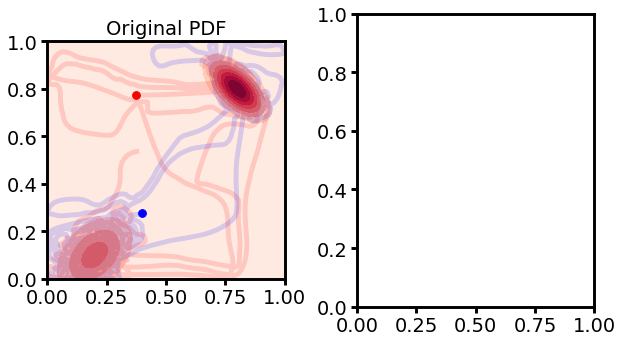

In [498]:
import matplotlib.cm as cm
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
#fig, axes = plt.subplots(figsize=(6, 4), dpi=100, tight_layout=True) #### For now only one plot as i do not wish to reconstruct.
ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
distinct_colors = [
    'red', 'blue', 'green', 'orange', 'purple',
    'cyan', 'magenta', 'brown', 'olive', 'black'
]
for i in range(N_agents):
    color = distinct_colors[i % len(distinct_colors)]
    ax.plot(x_traj[::10, 0, i], x_traj[::10, 1, i], linestyle='-', marker='', color=color, alpha=0.15, label=f'Trajectory {i}')
    ax.plot(x_traj[0, 0, i], x_traj[0, 1, i], linestyle='', marker='o', markersize=8, color=color, alpha=1.0, label=f'Init {i}')
#ax.legend(loc=1)

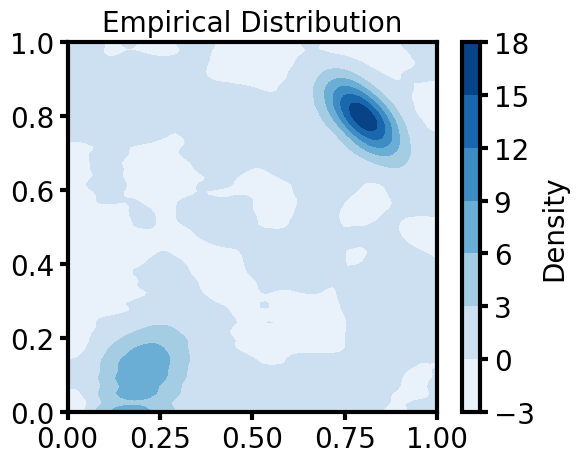

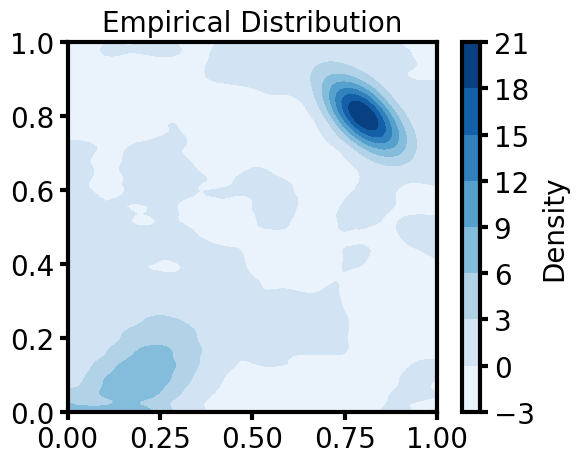

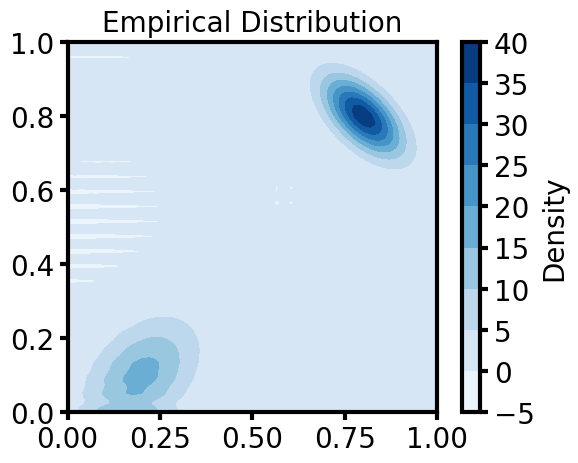

'   phi_recon = np.zeros(grids.shape[0])\n    for i, (k_vec, ck, hk) in enumerate(zip(ks, ck_list_update/(tsteps*dt), hk_list)):\n        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)\n        fk_vals /= hk\n        phi_recon += ck * fk_vals'

In [499]:
all_phi = np.zeros(grids.shape[0])
for i in range(N_agents):
    phi_recon = np.zeros(grids.shape[0])
    for i, (k_vec, ck, hk) in enumerate(zip(ks, phik_list_expanded[:,i], hk_list)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        fk_vals /= hk
        phi_recon += ck * fk_vals
    all_phi += phi_recon
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(0.0, L_list[0])
    ax.set_ylim(0.0, L_list[1])
    ax.set_title('Empirical Distribution')
    contour = ax.contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Blues')
    fig.colorbar(contour, ax=ax, label='Density')
    plt.show()
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Empirical Distribution')
contour = ax.contourf(grids_x, grids_y, all_phi.reshape(grids_x.shape), cmap='Blues')
fig.colorbar(contour, ax=ax, label='Density')
plt.show()

"""   phi_recon = np.zeros(grids.shape[0])
    for i, (k_vec, ck, hk) in enumerate(zip(ks, ck_list_update/(tsteps*dt), hk_list)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        fk_vals /= hk
        phi_recon += ck * fk_vals"""

In [500]:
### Make sure to change the filename here!
#import json
#with open(r'eval_data/Indicator.json', 'w') as f:
#    json.dump(results_indicator, f)

In [501]:
# reconstruct the emprical distribution
#phi_recon = np.zeros(grids.shape[0])
from scipy.spatial.distance import cdist
from numpy.linalg import solve
### Fourier
"""phi_recon = np.zeros(grids.shape[0])
for i, (k_vec, ck, hk) in enumerate(zip(ks, ck_list_update/(tsteps*dt), hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    fk_vals /= hk
    phi_recon += ck * fk_vals"""

### Indicator
# Compute basis functions
fks = np.zeros((grids.shape[0], len(ks)))
for i,_ in enumerate(ks):
    f1 = sig(grids,lower[i])
    f2 = sig(grids,upper[i])
    fks[:, i] = np.prod(f1 * (1 - f2), axis=-1)

# Compute Gram matrix and RHS vector
    
G = fks.T @ (fks * dx * dy)
# Solve for coefficients
c = np.linalg.solve(G + 1e-6 * np.eye(G.shape[0]), ck_list_update/(tsteps*dt))
phi_recon = fks @ c

### Radial
"""pairwise_dists = cdist(centers, centers)
G = (sigma * np.sqrt(np.pi))**centers.shape[1] * np.exp(-pairwise_dists**2 / (4 * sigma**2))
a = solve(G, ck_list_update/(tsteps*dt))
grid_dists = cdist(grids, centers) 
rbf_vals = np.exp(-grid_dists**2 / (2 * sigma**2)) 
phi_recon = rbf_vals @ a"""

## Multiple Radials
"""M = centers.shape[0]
N = sigmas.shape[0]
d = centers.shape[1]
pairwise_centers = cdist(centers, centers, 'sqeuclidean')  # shape (M, M)
G = np.zeros((M, M))
for i in range(N):
    for m in range(N):
        coef = (np.sqrt(np.pi) * np.sqrt(2 * sigmas[i]**2 * sigmas[m]**2 / (sigmas[i]**2 + sigmas[m]**2)))**d
        exp_term = np.exp(-pairwise_centers / (2 * (sigmas[i]**2 + sigmas[m]**2)))
        G += weights[i] * weights[m] * coef * exp_term
rhs = np.zeros(M)
for i in range(N):
    coef = (np.sqrt(np.pi) * np.sqrt(2) * sigmas[i])**d
    rhs += weights[i] * coef * ck_list_update / (tsteps * dt)
c = np.linalg.solve(G + 1e-6 * np.eye(M), rhs)

sq_dists = cdist(grids, centers, 'sqeuclidean')
rbf_vals = np.zeros((grids.shape[0], M))
for i in range(N):
    rbf_vals += weights[i] * np.exp(-sq_dists / (2 * sigmas[i]**2))

phi_recon = rbf_vals @ c"""

# visualize the trajectory
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
#fig, axes = plt.subplots(figsize=(6, 4), dpi=100, tight_layout=True) #### For now only one plot as i do not wish to reconstruct.
ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Empirical Distribution')
ax.contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Blues')
ax.plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # adjust if title overlaps with subplots
#fig.suptitle(f"Radial basis with \sigma {sigmas[0][0]} on {num_k_per_dim}x{num_k_per_dim} Grid for {dt * tsteps} seconds", fontsize=16)
plt.show()
plt.close()

results = compare_pdfs(pdf_vals, phi_recon)
for name, value in results.items():
    print(f"{name}: {value:.6f}")



NameError: name 'sig' is not defined

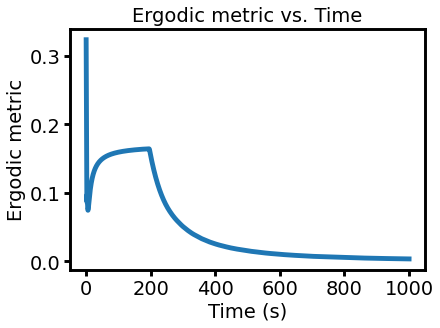

In [ ]:
# Also visualize the ergodic metric over time
fig, ax = plt.subplots(1, 1, dpi=70, tight_layout=True)

ax.plot(np.arange(tsteps)*dt, metric_log)
ax.set_title('Ergodic metric vs. Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Ergodic metric')

plt.show()
plt.close()

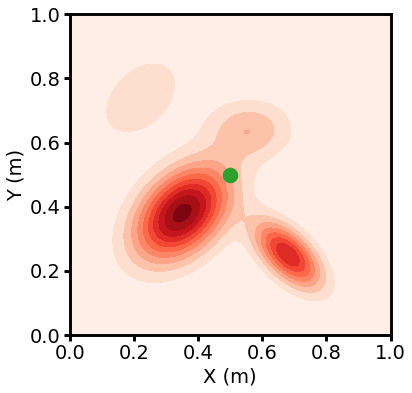

In [ ]:
# Generate animation (takes about 1 minute)
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(6,7), dpi=70, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', levels=10)

robot_traj, = ax.plot([], [], linestyle='-', marker='', color='k', alpha=0.2)
robot_state, = ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2')

def update_plot(frame):
    t = int(frame * 10)
    robot_state.set_data(
        np.array([x_traj[t][0]]), np.array([x_traj[t][1]])
    )
    robot_traj.set_data(
        x_traj[:t,0][::10], x_traj[:t,1][::10]
    )

    return robot_state, robot_traj,

#ani = animation.FuncAnimation(fig, update_plot, frames=int(tsteps/10)-1, blit=True, interval=30, repeat=False)
#video = ani.to_html5_video()
#HTML(video)